# Bird Species Transfer Learning and Fine-tuning

This notebook uses the VGG16 pre-trained model from TensorFlow and fine-tunes it to classify bird species with the best possible performance.

## Imports and Data Loading

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from PIL import Image
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import data as tf_data
import tensorflow.keras as keras
from tensorflow.keras import Input, layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [ ]:
# Define path to data directory
data_dir = 'data'

In [ ]:
# Define directories
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')
pred_dir = os.path.join(data_dir, 'images to predict')

## EDA

In [ ]:
# Get subfolders
subfolders = [d.name for d in Path(data_dir).iterdir() if d.is_dir()]
subfolders

['images to predict', 'test', 'train', 'valid']

In [ ]:
# Get total number of images in dataset
complete_list = list(Path(data_dir).glob('*/*/*.jpg'))
nb_images = len(complete_list)
nb_images

3408

In [ ]:
# Get size of training set
train_img_paths = list(Path(train_dir).glob('*/*.jpg'))
train_size = len(train_img_paths)
train_size

3208

In [ ]:
# Get size of validation set
val_img_paths = list(Path(val_dir).glob('*/*.jpg'))
val_size = len(val_img_paths)
val_size

100

In [ ]:
# Get size of test set
test_img_paths = list(Path(test_dir).glob('*/*.jpg'))
test_size = len(test_img_paths)
test_size

100

In [ ]:
# Get number of images to predict
pred_img_paths = list(Path(pred_dir).glob('*.jpg'))
pred_size = len(pred_img_paths)
pred_size

6

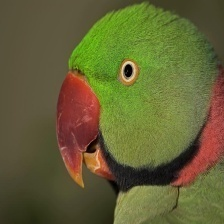

In [ ]:
# Load one image from dataset at random
np.random.seed(42)
random_img_path = np.random.choice(complete_list)
random_img = Image.open(random_img_path)
display(random_img)

In [ ]:
# Get size of that image
random_img.size

(224, 224)

## Data Preprocessing

In [ ]:
# Define image size
img_height = 150
img_width = 150

In [ ]:
# Preprocess the train set
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=0.2,
    horizontal_flip=True)
train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size=(img_width, img_height),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True)

Found 3208 images belonging to 20 classes.


In [ ]:
# Preprocess the validation set
valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_set = valid_datagen.flow_from_directory(val_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False)

Found 100 images belonging to 20 classes.


In [ ]:
# Preprocess the test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False)

Found 100 images belonging to 20 classes.


## Data Modeling

### Load pre-trained model

In [ ]:
# Load base model with the top classification layer
initial_model = VGG16(weights="imagenet")

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Test some images

In [ ]:
# Function to load and preprocess an image
def load_and_preprocess_image(img_path, size):
    img = load_img(img_path, target_size=size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

#### Compare labels from base model and dataset

In [ ]:
# Get 5 images at random
np.random.seed(42)
rand_img_paths = np.random.choice(complete_list, 5, replace=False)

preds = []

for img_path in rand_img_paths:
  image = Image.open(img_path)
  img = load_and_preprocess_image(img_path, (224, 224))
  actual = os.path.basename(os.path.dirname(img_path))
  y_pred = initial_model.predict(img)
  pred_id, pred_label, confidence = decode_predictions(y_pred, top=1)[0][0]

  preds.append({
      'image': image,
      'predicted': f'{pred_label} ({confidence:.2%})',
      'actual': actual
  })

val_df = pd.DataFrame(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


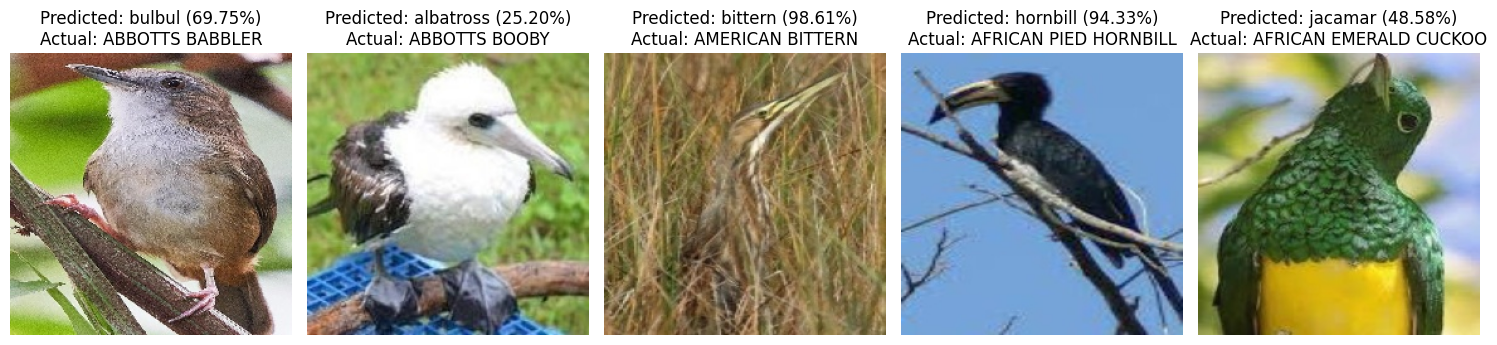

In [ ]:
# Display images and labels
images = val_df['image'].to_list()
actual = val_df['actual'].to_list()
predicted = val_df['predicted'].to_list()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

for i in range(5):
    title = f'Predicted: {predicted[i]}\nActual: {actual[i]}'
    axes[i].imshow(images[i])
    axes[i].title.set_text(title)
    axes[i].axis('off')

fig.tight_layout()
plt.show()

The third and fourth predictions are correct.

#### Get labels of images to predict

In [ ]:
def display_images(df: pd.DataFrame) -> None:
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,5))
  images = df['image'].to_list()
  base_pred = df['base_pred'].to_list()
  new_pred = df['new_pred'].to_list() if 'new_pred' in df.columns else None

  for i, ax in enumerate(axes.flatten()):
    new_pred_label = '\nNew model: ' + new_pred[i] if new_pred else ''
    title = f'Base model: {base_pred[i]}{new_pred_label}'
    ax.imshow(images[i])
    ax.title.set_text(title)
    ax.axis('off')

  fig.tight_layout()
  plt.show()

In [ ]:
# Create dataframe with images to predict
pred_img_paths = sorted(pred_img_paths)
to_predict = []

for img_path in pred_img_paths:
  image = Image.open(img_path)
  img = load_and_preprocess_image(img_path, (224, 224))
  yhat = initial_model.predict(img)
  pred_id, pred_label, confidence = decode_predictions(yhat, top=1)[0][0]

  to_predict.append({
      'img_path': img_path,
      'image': image,
      'base_pred': f'{pred_label} ({confidence:.2%})',
  })
to_predict_df = pd.DataFrame(to_predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


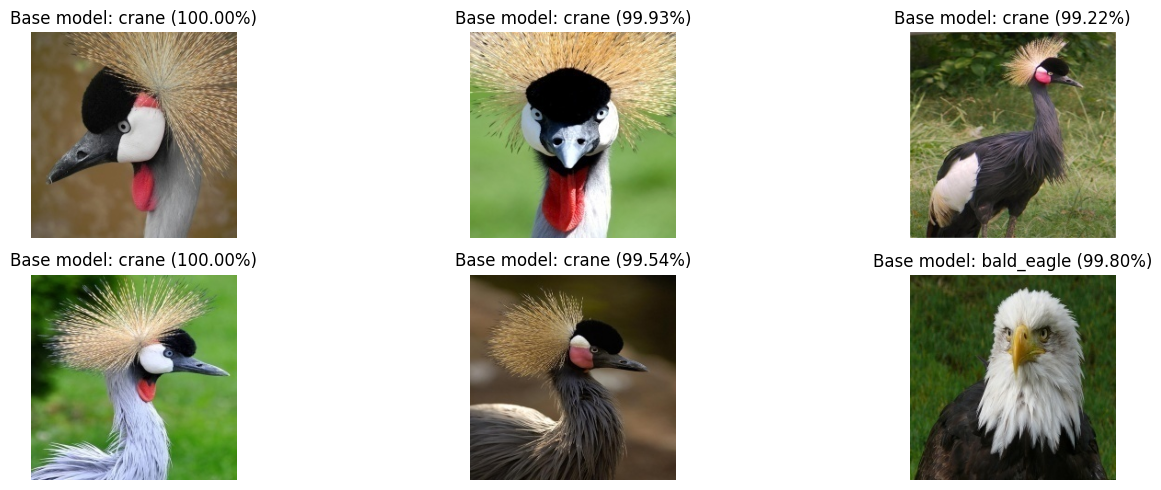

In [ ]:
# Display images
display_images(to_predict_df)

All the predictions are correct.

### Fine-tune model

#### Train the top layer

In [ ]:
# Build model without the original classification layer
base_model = VGG16(
    weights="imagenet",
    input_shape=(img_width, img_height, 3),
    include_top=False,
)

In [ ]:
# Freeze the base_model
base_model.trainable = False

In [ ]:
# Add additional layers
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x) # regularization
outputs = keras.layers.Dense(20, activation='softmax')(x) # classification layer
model = keras.Model(inputs=base_model.input, outputs=outputs)
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 150, 150, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 150, 150, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 75, 75, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 75, 75, 128)   │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 75, 75, 128)   │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 37, 37, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 37, 37, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 37, 37, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 37, 37, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 18, 18, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 18, 18, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 18, 18, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 18, 18, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 9, 9, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 9, 9, 512)     │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 9, 9, 512)     │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 9, 9, 512)     │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 4, 4, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 8192)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 256)           │  2,097,408 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 256)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 20)            │      5,140 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 16,817,236 (64.15 MB)

 Trainable params: 2,102,548 (8.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Compile
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
# Fit
early_stop = EarlyStopping(monitor='val_loss', patience=1)
model.fit(train_set, epochs=100, validation_data=valid_set, verbose=1, callbacks=[early_stop])

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 971s 10s/step - accuracy: 0.1490 - loss: 2.8642 - val_accuracy: 0.6800 - val_loss: 1.6673
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 43s 421ms/step - accuracy: 0.4571 - loss: 1.8692 - val_accuracy: 0.7600 - val_loss: 1.0822
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 32s 313ms/step - accuracy: 0.5857 - loss: 1.4042 - val_accuracy: 0.8400 - val_loss: 0.7802
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 33s 329ms/step - accuracy: 0.7013 - loss: 1.0854 - val_accuracy: 0.8700 - val_loss: 0.6435
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 299ms/step - accuracy: 0.7390 - loss: 0.9397 - val_accuracy: 0.9000 - val_loss: 0.5396
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 302ms/step - accuracy: 0.7494 - loss: 0.8571 - val_accuracy: 0.9200 - val_loss: 0.4892
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 299ms/step - accuracy: 0.7749 - loss: 0.7846 - val_accuracy: 0.9200 - val_loss: 0.4186
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 298ms/step - accuracy: 0.8015 - 

In [ ]:
# Show metrics history
metrics_top = pd.DataFrame(model.history.history)
metrics_top

,accuracy,loss,val_accuracy,val_loss
0,0.235973,2.558328,0.68,1.667325
1,0.507793,1.738861,0.76,1.082163
2,0.616584,1.335172,0.84,0.780235
3,0.693579,1.096632,0.87,0.643477
4,0.731920,0.956225,0.90,0.539641
5,0.764963,0.837232,0.92,0.489196
6,0.778055,0.764744,0.92,0.418585
7,0.807357,0.683675,0.91,0.384286
8,0.815773,0.640536,0.91,0.362556
9,0.840399,0.575251,0.90,0.374295


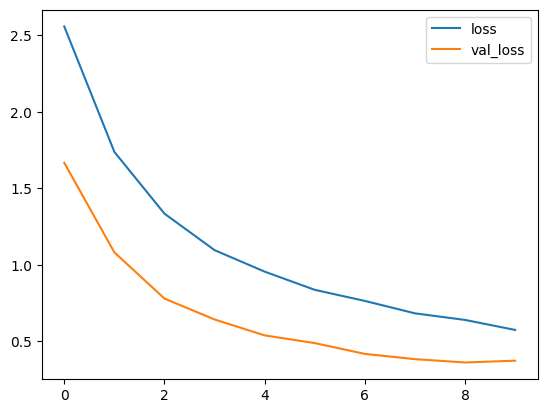

In [ ]:
# Plot training vs. validation loss
metrics_top[['loss','val_loss']].plot();

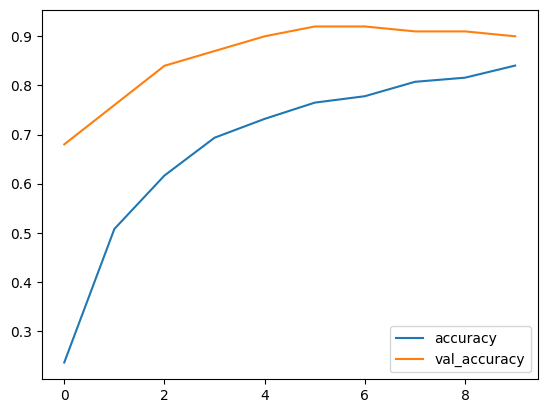

In [ ]:
# Plot training vs. validation accuracy
metrics_top[['accuracy','val_accuracy']].plot();

#### Train all the layers


In [ ]:
# Unfreeze the base model
base_model.trainable = True
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 150, 150, 64)  │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 150, 150, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 75, 75, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 75, 75, 128)   │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 75, 75, 128)   │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 37, 37, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 37, 37, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 37, 37, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 37, 37, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 18, 18, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 18, 18, 512)   │  1,180,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 18, 18, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 18, 18, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 9, 9, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 9, 9, 512)     │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 9, 9, 512)     │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 9, 9, 512)     │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 4, 4, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 8192)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 256)           │  2,097,408 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 256)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 20)            │      5,140 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 21,022,334 (80.19 MB)

 Trainable params: 16,817,236 (64.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,205,098 (16.04 MB)

In [ ]:
# Compile
model.compile(
    optimizer=keras.optimizers.Adam(1e-5), # very low learning rate, because the model is larger
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
# Fit
early_stop = EarlyStopping(monitor='val_loss', patience=1)
model.fit(train_set, epochs=100, validation_data=valid_set, verbose=1, callbacks=[early_stop])

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 77s 513ms/step - accuracy: 0.8645 - loss: 0.4367 - val_accuracy: 0.9400 - val_loss: 0.2232
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 35s 345ms/step - accuracy: 0.8994 - loss: 0.2925 - val_accuracy: 0.9500 - val_loss: 0.1221
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 35s 342ms/step - accuracy: 0.9310 - loss: 0.2285 - val_accuracy: 0.9700 - val_loss: 0.0862
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 36s 352ms/step - accuracy: 0.9299 - loss: 0.2063 - val_accuracy: 0.9600 - val_loss: 0.1083


In [ ]:
# Show metrics history
metrics_all = pd.DataFrame(model.history.history)
metrics_all

,accuracy,loss,val_accuracy,val_loss
0,0.878429,0.398905,0.94,0.223210
1,0.903990,0.297228,0.95,0.122118
2,0.931421,0.224307,0.97,0.086229
3,0.933292,0.195849,0.96,0.108283


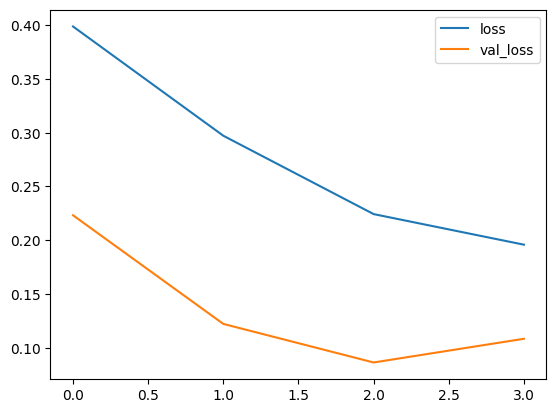

In [ ]:
# Plot training vs. validation loss
metrics_all[['loss','val_loss']].plot();

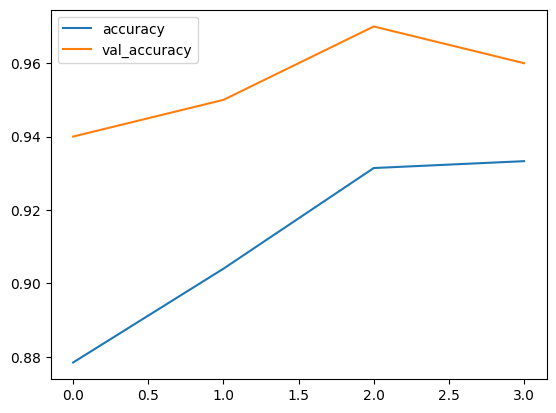

In [ ]:
# Plot training vs. validation accuracy
metrics_all[['accuracy','val_accuracy']].plot();

In [ ]:
# Save model
model.export('bird_classifier')

### Evaluate model on test set

In [ ]:
# Build classification report
labels = list(test_set.class_indices.values())
target_names = list(test_set.class_indices.keys())

y_pred = model.predict(test_set)
test_set.reset()
y_true = []
for i in range(len(test_set)):
    y_true.extend(np.argmax(test_set[i][1], axis=1))

y_true = np.array(y_true)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_pred_classes, labels=labels, target_names=target_names))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 250ms/step
                            precision    recall  f1-score   support

           ABBOTTS BABBLER       1.00      0.80      0.89         5
             ABBOTTS BOOBY       1.00      0.60      0.75         5
ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
     AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
    AFRICAN EMERALD CUCKOO       0.83      1.00      0.91         5
         AFRICAN FIREFINCH       0.83      1.00      0.91         5
    AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
     AFRICAN PIED HORNBILL       1.00      1.00      1.00         5
       AFRICAN PYGMY GOOSE       0.83      1.00      0.91         5
                 ALBATROSS       0.83      1.00      0.91         5
            ALBERTS TOWHEE       1.00      0.80      0.89         5
      ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
             ALPINE CHOUGH       1.00      0.80      0.89         5
   

The overall accuracy is 94%. The model did pretty good on all the classes, not so good on the abbotts booby.

## Make predictions

In [ ]:
# Add new model predictions to dataframe
def add_pred_label(row):
  img_path = row['img_path']
  img = load_and_preprocess_image(img_path, (img_width, img_height))
  y_pred = model.predict(img)
  pred_id = np.argmax(y_pred)
  confidence = np.max(y_pred)
  pred_label = list(test_set.class_indices.keys())[list(test_set.class_indices.values()).index(pred_id)]

  return f'{pred_label} ({confidence:.2%})'

to_predict_df['new_pred'] = to_predict_df.apply(add_pred_label, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


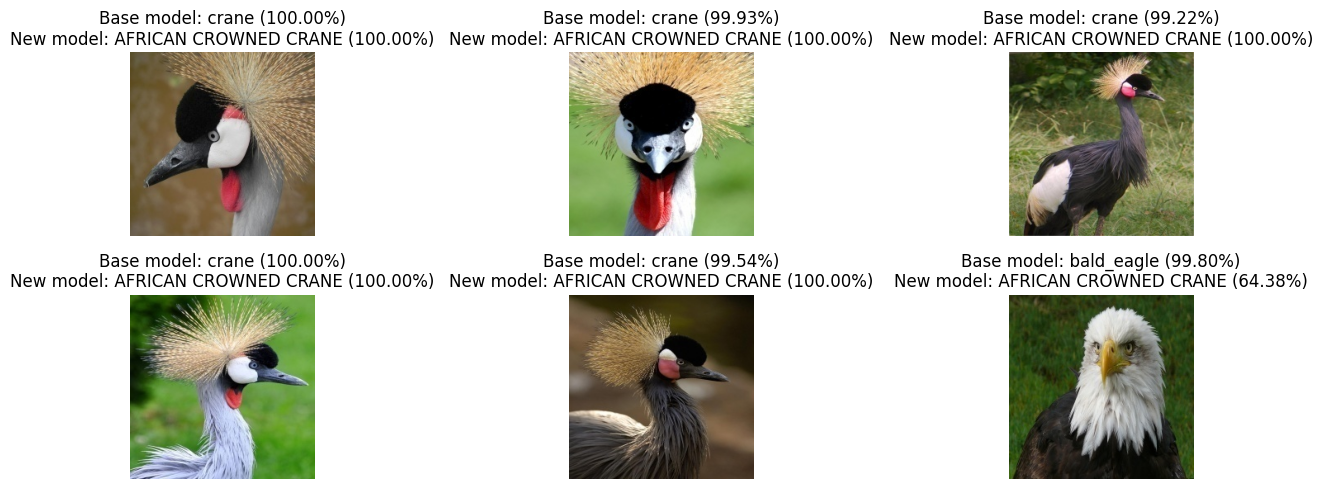

In [ ]:
# Display images
display_images(to_predict_df)

The first 5 are correct except the last one, because the dataset didn't have bald eagle pictures.

## End